# Random Forest Regression: Quasars

This notebook is based on [NN_SVM_RF_classification_supervised_Evaluated.ipynb](https://github.com/RichardsGroup/AGN_DataChallenge/blob/main/submissions/SER-SAG/NN_SVM_RF_classification_supervised_Evaluated.ipynb) submission to the LSST AGN Data Challenge by SER-SAG.

Authors: Djordje Savic (Postdoc), Isidora Jankov (PhD student), Iva Čvorović-Hajdinjak (PhD student)

## Data reading, selection and pre-processing

In [1]:
## commonly used modules
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
import yaml
import seaborn as sns
import importlib

from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import datasets 
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor
import sklearn.model_selection as model_selection
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.metrics import f1_score
#from sklearn.metrics import plot_confusion_matrix #command is deprecated
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', 1000)

### Data selection
The object table follows the current version of the LSST Data Products document (LSE-163) as much as possible with measurements of included objects in the following main catalogries:
- __Astromety__ -> ra, dec, proper motion and parallax
- __Photometry__ -> point and extended source photometry, in both AB magnitdues and fluxes (nJy)
- __Color__ -> Computed using the fluxes
- __Morphology__ -> 1 for extended and 0 for point-like
- __Light Curve Features__ -> Extrated on the SDSS light curves if matched
- __Redshift__ -> Both spectroscopic and photometric, wherever available

The data used here is from the 's82ObjectTable.parquet' file available online on [Zenodo](https://zenodo.org/records/6862159).

In [2]:
sample1 = pd.read_csv('select_attributes1.csv', index_col=0)

In [3]:
sample1

,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,class,z
objectId,,,,,,,
271386,2.047289,1.542644,1.517730,0.691103,0.180547,Star,0.000000
271388,2.628649,1.437541,0.672900,0.403049,NaN,Star,0.000000
271389,0.506060,-0.086831,-0.137316,-0.160921,NaN,Star,0.000000
271390,1.318985,0.514469,0.154915,0.077669,-0.012270,Star,0.000000
271391,0.964024,0.301733,0.076412,0.028065,-0.041763,Star,0.000000
...,...,...,...,...,...,...,...
1468017,0.451338,0.154067,0.368441,0.338225,NaN,Qso,0.442569
1468018,0.065456,0.106526,-0.103106,-0.005643,NaN,Qso,1.110641
1468019,0.156834,0.123606,0.331176,0.023310,NaN,Qso,1.775506


In [4]:
# Changing the class value to numerical for using sparse categorical cross entropy loss from tensorflow
# Also moving Agn and highZQso to Qso label
sample1_good = sample1.replace({'class': {'Star': 0, 'Gal': 1, 'Qso': 2, 'Agn': 2, 'highZQso': 2}})
sample1_good

,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,class,z
objectId,,,,,,,
271386,2.047289,1.542644,1.517730,0.691103,0.180547,0.0,0.000000
271388,2.628649,1.437541,0.672900,0.403049,NaN,0.0,0.000000
271389,0.506060,-0.086831,-0.137316,-0.160921,NaN,0.0,0.000000
271390,1.318985,0.514469,0.154915,0.077669,-0.012270,0.0,0.000000
271391,0.964024,0.301733,0.076412,0.028065,-0.041763,0.0,0.000000
...,...,...,...,...,...,...,...
1468017,0.451338,0.154067,0.368441,0.338225,NaN,2.0,0.442569
1468018,0.065456,0.106526,-0.103106,-0.005643,NaN,2.0,1.110641
1468019,0.156834,0.123606,0.331176,0.023310,NaN,2.0,1.775506


In [5]:
# dropping nan values
sample1_good = sample1_good.dropna()

display(sample1_good.columns, sample1_good.describe())

Index(['stdColor_0', 'stdColor_1', 'stdColor_2', 'stdColor_3', 'stdColor_4',
       'class', 'z'],
      dtype='object')

,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,class,z
count,251092.000000,251092.000000,251092.000000,251092.000000,251092.000000,251092.000000,251092.000000
mean,1.192455,0.796617,0.458105,0.246363,0.137506,0.969585,0.699422
std,1.097236,0.577364,0.350144,0.179869,0.181409,0.717093,0.706082
min,-3.456974,-4.951052,-8.632828,-2.787663,-3.639812,0.000000,-0.006079
25%,0.383977,0.338318,0.165244,0.097926,0.010907,0.000000,0.000000
50%,0.989902,0.611921,0.444655,0.257902,0.111104,1.000000,0.602561
75%,1.892795,1.360131,0.669739,0.372838,0.225287,1.000000,0.925258
max,16.439950,8.568064,2.936810,4.250202,2.608742,2.000000,7.011245


### Data preprocessing 

In [6]:
# choose the records with class = 2 (quasars)
only_qso = sample1_good[sample1_good['class']==2.0]
only_qso

,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,class,z
objectId,,,,,,,
697454,0.662237,1.104010,0.762233,0.219076,0.281439,2.0,0.536461
698195,1.024983,0.654579,0.254540,0.241489,0.111748,2.0,0.113405
698558,-0.088183,0.757585,0.567576,0.202108,0.258708,2.0,0.557635
698575,1.333504,1.175553,0.483101,0.384510,0.291141,2.0,0.190141
698681,1.025274,0.972344,0.268497,0.465105,0.021840,2.0,0.377762
...,...,...,...,...,...,...,...
1467479,0.480263,0.647133,0.185295,0.087828,0.197606,2.0,1.353339
1467481,0.404208,0.272697,0.055519,0.148398,-0.062617,2.0,0.903731
1467482,1.717676,-0.179669,0.315848,0.627024,0.443895,2.0,0.925798


In [7]:
#attr_list = ['stdColor_0','stdColor_1','stdColor_2','stdColor_3','stdColor_4','class','z']

In [8]:
#we need to drop Na values from all columns
#print(len(only_gal))

#for attr in attr_list:
    #print(attr)
#    only_gal = only_gal.dropna(subset=[attr])

#print(len(only_gal))

In [9]:
only_qso.to_csv('only_gal_good.csv')

In [10]:
only_qso = pd.read_csv('only_gal_good.csv')

In [11]:
print(len(only_qso))

60856


In [12]:
#half the sample to reduce computational time
only_qso = only_qso[:int((len(only_qso)-1)/2)]

In [13]:
print(len(only_qso))

30427


In [14]:
#splitting into X and y values

X = only_qso
# removing the z attribute from X data array
X = X.drop(['z'], axis=1)

# storing labels for later
y = only_qso['z']

display(X.shape, y.shape)
display(X.describe()) #no z property

(30427, 7)

(30427,)

,objectId,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,class
count,3.042700e+04,30427.000000,30427.000000,30427.000000,30427.000000,30427.000000,30427.0
mean,1.393075e+06,0.503828,0.265666,0.161460,0.131854,0.071341,2.0
std,8.507190e+04,0.705128,0.276161,0.173886,0.158582,0.167852,0.0
min,6.974540e+05,-2.164861,-0.858626,-0.763548,-0.669849,-3.639812,2.0
25%,1.394640e+06,0.094520,0.091603,0.033504,0.011684,-0.037714,2.0
50%,1.405386e+06,0.390184,0.221009,0.144555,0.117705,0.051091,2.0
75%,1.415508e+06,0.760534,0.359688,0.263287,0.237976,0.151153,2.0
max,1.425707e+06,10.609983,2.925405,1.800148,4.250202,1.334640,2.0


In [15]:
## Splitting data to train, test followed by standardization
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 1)

## standardization using StandardScaler applied to X_train (yields mean and sigma for X_train)
## and then standardizing X_train and X_test with mean and sigma obtained from X_train

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

display(X_train.shape, X_test.shape)

(24341, 7)

(6086, 7)

## Random forest regression

- A supervised machine learning algorithm - input data is labelled.
- Combines multiple decision trees to create a single model.
- Each tree builds from a different subset of the data (which is randomly chosen) to make an independent prediction.
- The final prediction for input is based on the average or weighted average of all the individual trees' predictions.

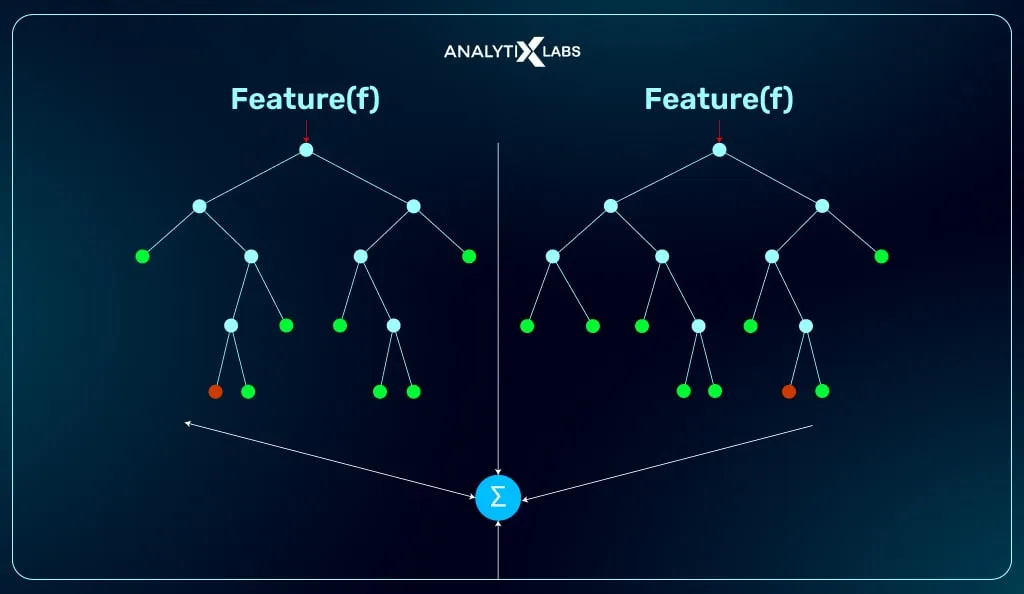

Source: [Medium](https://medium.com/@byanalytixlabs/random-forest-regression-how-it-helps-in-predictive-analytics-01c31897c1d4)

In [16]:
clf=RandomForestRegressor(max_depth=50, random_state=5, n_jobs=70, criterion="squared_error")

Source: [scikit-learn](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [17]:
print(X_train.shape)
print(y_train.shape)
y_2=np.array(y_train).ravel()
print(y_2.shape) #needs to be ravelled

(24341, 7)
(24341,)
(24341,)


In [18]:
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, n_jobs=70, random_state=5)

In [19]:
y_pred_test=clf.predict(X_test)

In [20]:
#save our results
np.savetxt('y_pred_test.csv', y_pred_test, delimiter=',')

In [21]:
y_pred_train=clf.predict(X_train)

In [22]:
#save our results
np.savetxt('y_pred_train.csv', y_pred_train, delimiter=',')

In [23]:
#loading the data
y_pred_test = np.loadtxt('y_pred_test.csv', delimiter=',')
y_pred_train = np.loadtxt('y_pred_train.csv', delimiter=',')

In [24]:
print('Test lengths: ', len(y_pred_test), len(y_test))
print('Train lengths: ', len(y_pred_train), len(y_train))

Test lengths:  6086 6086
Train lengths:  24341 24341


### Statistics on test data

$R^2$ score (coefficient of determination) represents how well predictions of a regression model fit the actual data. A larger $R^2$ score usually represents a better fit.

In [25]:
print('Results for test data')
print(f"MSE: {mean_squared_error(y_test, y_pred_test)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test)}")
print(f"R2 score: {r2_score(y_test, y_pred_test)}")

Results for test data
MSE: 0.24870638808242138
MAE: 0.32962361659598455
R2 score: 0.5005554834884023


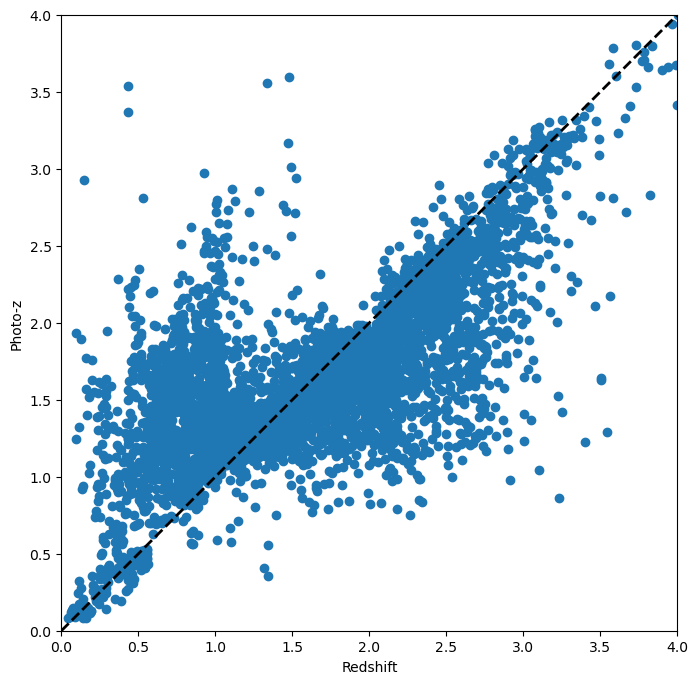

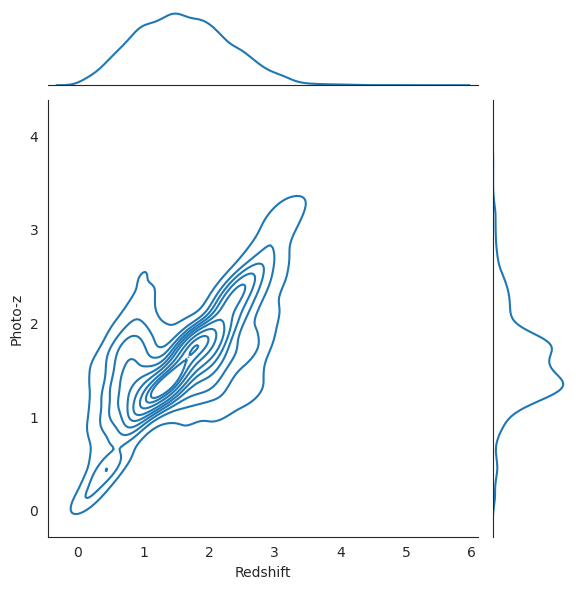

In [26]:
yydf = pd.DataFrame({'Redshift':y_test, 'Photo-z':y_pred_test})

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_test, y_pred_test)
ax.set_xlabel('Redshift')
ax.set_ylabel('Photo-z')
ax.plot([0, 4], [0, 4], 'k--', linewidth = 2)
ax.set_xlim((0, 4))
ax.set_ylim((0, 4))
ax.set_aspect('equal')
with sns.axes_style('white'):
    sns.jointplot(data=yydf, x='Redshift', y='Photo-z', kind='kde')

-0.0027165624027541877 0.49869731137347567


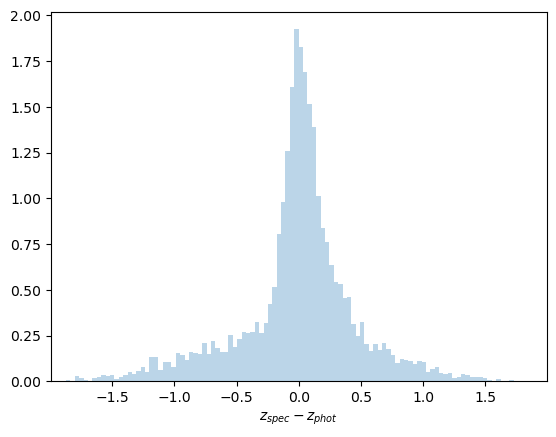

In [27]:
sig_pred_test = np.std(y_test - y_pred_test)
mean_pred_test = np.mean(y_test - y_pred_test)

plt.hist(y_test-y_pred_test, histtype='stepfilled', alpha=0.3, density=True, bins=200);
plt.xlim(-4*sig_pred_test, 4*sig_pred_test)
plt.xlabel(r'$z_{spec} - z_{phot}$')
print(mean_pred_test, sig_pred_test)

### Statistics on training data

In [28]:
print('Results for train data')
print(f"MSE: {mean_squared_error(y_train, y_pred_train)}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train)}")
print(f"R2 score: {r2_score(y_train, y_pred_train)}")

Results for train data
MSE: 0.03716574158180911
MAE: 0.1234835431611318
R2 score: 0.9276893476587881


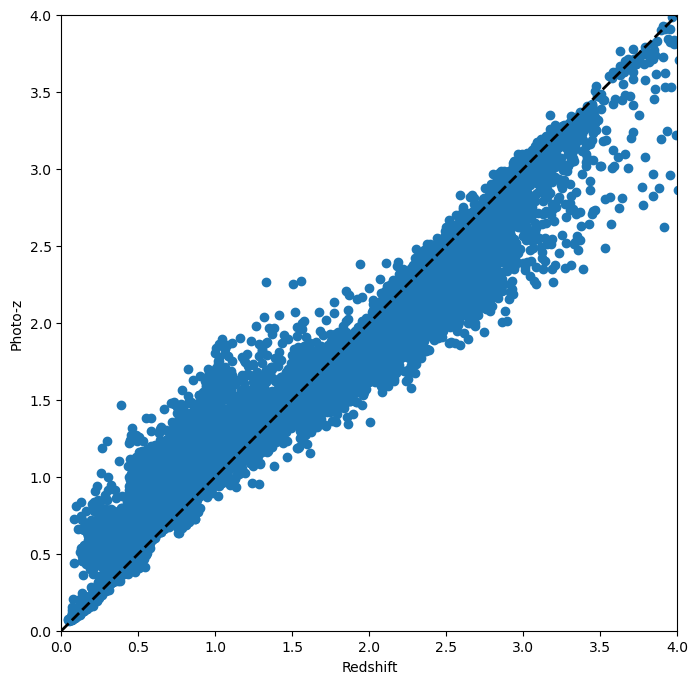

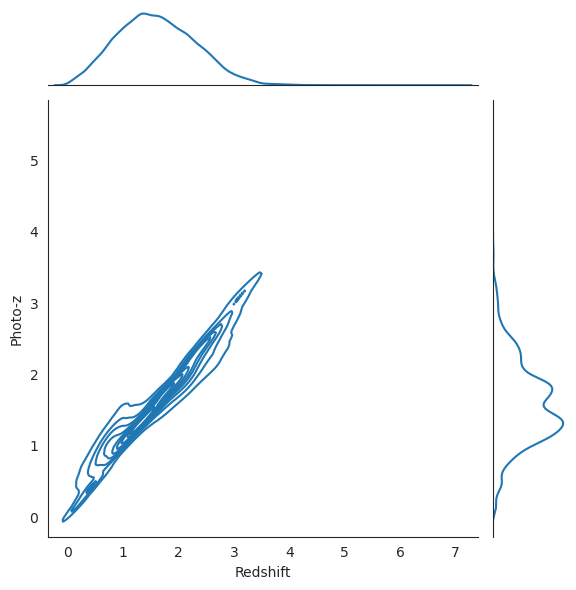

In [29]:
yydf = pd.DataFrame({'Redshift':y_train, 'Photo-z':y_pred_train})

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_train, y_pred_train)
ax.set_xlabel('Redshift')
ax.set_ylabel('Photo-z')
#plot y=x line
ax.plot([0, 4], [0, 4], 'k--', linewidth = 2)
ax.set_xlim((0, 4))
ax.set_ylim((0, 4))
ax.set_aspect('equal')
with sns.axes_style('white'):
    sns.jointplot(data=yydf, x='Redshift', y='Photo-z', kind='kde')

0.00035276528948276014 0.19278386119812946


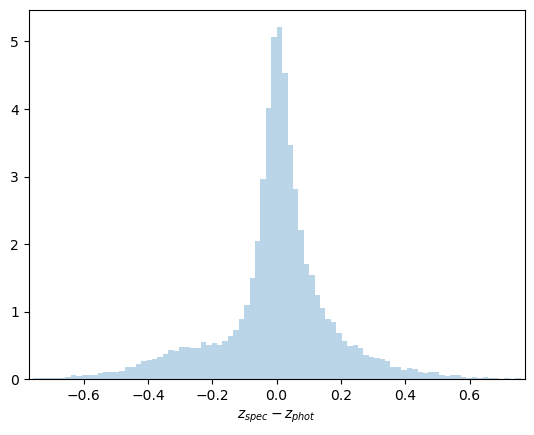

In [30]:
sig_pred_train = np.std(y_train - y_pred_train)
mean_pred_train = np.mean(y_train - y_pred_train)

plt.hist(y_train-y_pred_train, histtype='stepfilled', alpha=0.3, density=True, bins=200);
plt.xlim(-4*sig_pred_train, 4*sig_pred_train)
plt.xlabel(r'$z_{spec} - z_{phot}$')
print(mean_pred_train, sig_pred_train)